## Sensitivity of Concentration to Rate Constant and Initial Condition

jbr book reference: [Figure A.3](https://sites.engineering.ucsb.edu/~jbraw/chemreacfun/fig-html/appendix/fig-A-3.html)

Reaction is $A \xrightarrow[]{k_1} B$

Analytical solution:
$$
c_A(t) = c_{A0}e^{-k_1t}
$$
Sensitivity:
$$
\begin{eqnarray}
\frac{dc_A}{dk_1} &=& -tc_{A0}e^{-k_1t} \\
\frac{dc_A}{dc_{A0}} &=& e^{-k_1t}
\end{eqnarray}
$$
In this example, $c_{A0} = 2\;mol/L$, $k_1 = 1\;min^{-1}$

In [74]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
from kipet.library.EstimabilityAnalyzer import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd

In [75]:
# Though the sensitivity calculation doesn't need data, in KIPET sensitivity is part of Estimability routine 
# which needs concentration data. So the concentration data is simulated first prior to getting sensitivity
builder = TemplateBuilder()  
    
builder.add_mixture_component('A', 2.0)
builder.add_parameter('k1', 1.0)
    
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

In [76]:
# simulate to get the data
simulator = PyomoSimulator(opt_model)
simulator.apply_discretization('dae.collocation', ncp = 1, nfe = 60, scheme = 'LAGRANGE-RADAU')
results_pyomo = simulator.run_sim('ipopt',tee=True)

Ipopt 3.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:      301
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      121
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      121
Total number of inequali

In [77]:
# data
C_data = results_pyomo.Z
C_data.head()

,A
0.000000,2.000000
0.166667,1.714285
0.333333,1.469388
0.500000,1.259475
0.666667,1.079550


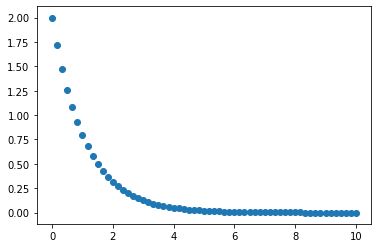

In [78]:
fig, ax = plt.subplots()
ax.scatter(C_data.index, C_data['A'])

In [79]:
# build the model again for getting sensitivity
builder = TemplateBuilder()  
    
builder.add_mixture_component('A', 2.0)

builder.add_parameter('k1', bounds = (0.1, 10)) # rate constant
builder.add_parameter('ca0') # initial condition listed as parameters since we want sensitivity w.r.t ca0

def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1']*m.Z[t,'A']
    return exprs

builder.add_concentration_data(C_data)
builder.set_odes_rule(rule_odes)
opt_model = builder.create_pyomo_model(0.0,10.0)

# specify values of parameters at which sensitivity is desired
opt_model.P['k1'].value = 1.0
opt_model.P['ca0'].value = 2.0

# we need an explicit constraint for conc(A) at time 0 = ca0
opt_model.ca0_cons = Constraint(expr = opt_model.Z[0, 'A'] == opt_model.P['ca0'])

In [80]:
# since we impose a constraint above for conc(A) at time 0, we need to relax the automatic initial condition 
# constraint on conc(A) at time 0 = 2 from the model
opt_model.init_conditions_c['A'].deactivate()
opt_model.init_conditions_c.pprint()

init_conditions_c : Size=1, Index=states, Active=True
    Key : Lower : Body     : Upper : Active
      A :   2.0 : Z[0.0,A] :   2.0 :  False


In [81]:
e_analyzer = EstimabilityAnalyzer(opt_model)
e_analyzer.apply_discretization('dae.collocation', nfe = 60, ncp = 2, scheme = 'LAGRANGE-RADAU')

In [82]:
sigmas = {'A': 1} # we can just keep this as one since we want unscaled sensitivity
dsdp, idx_to_param = e_analyzer.get_sensitivities_for_params(tee=True, sigmasq=sigmas)

W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG]...	[K_AUG_ASL]This problem has no degrees of freedom
Pass the option square_override for the desired behaviour
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zL_out suffix declared, setting zL = 0.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dsdp_in_.in
W[K_AUG]...	[K_AUG_ASL]dsdp for linear C(x) + I*p = 0 override.


[K_AUG] written by D.T. @2018

: dsdp_mode=
dsdp_mode=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 243
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 243
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 0
I[K_AUG]...	[ADJUST_MU]	Warning no relevant info from the problem can predict logmu
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 243, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 844
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 181
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.038068
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 182
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 scaling...
I[K_AUG]...	[ASSM_RHS_DCDP]According to the suffixes declared

In [83]:
# get the sensitivities and compare with analytical sensitivities
tlist = np.array(e_analyzer.model.allmeas_times)
sens = dsdp.copy()
dca_dk1 = sens[:, 0]
dca_dca0 = sens[:, 1]
dca_dk1_act = -tlist * 2 * np.exp(-tlist) # sensitivity dca/dk1 = -t*ca0*exp(-k1*t), ca0 = 2, k1 = 1
dca_dca0_act = np.exp(-tlist) # sensitivity dca/dca0 = exp(-k1*t), k1 = 1

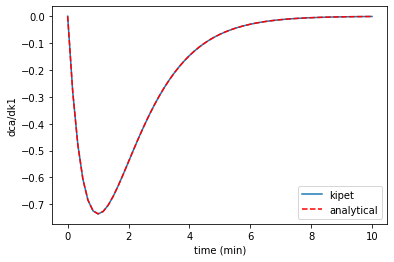

In [84]:
fig, ax = plt.subplots()
ax.plot(tlist, dca_dk1, label = 'kipet')
ax.plot(tlist, dca_dk1_act,'--r', label = 'analytical')
ax.set_xlabel('time (min)')
ax.set_ylabel('dca/dk1')
ax.legend()

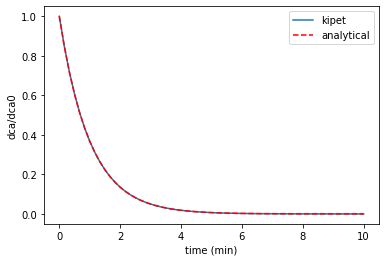

In [85]:
fig, ax = plt.subplots()
ax.plot(tlist, dca_dca0, label = 'kipet')
ax.plot(tlist, dca_dca0_act,'--r', label = 'analytical')
ax.set_xlabel('time (min)')
ax.set_ylabel('dca/dca0')
ax.legend()